<a href="https://colab.research.google.com/github/OlegLaiok/Comp_Lingv/blob/homework10/%D0%9B%D0%B0%D0%B1_10_%D0%B8%D1%81%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install pymorphy2
!pip install pyLDAvis
!pip install --upgrade pandas==1.2

Requirement already up-to-date: pandas==1.2 in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [43]:
import nltk
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pandas as pd
import pymorphy2
import json
from gensim.models import LdaMulticore
from multiprocessing import Process, freeze_support
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
from gensim.models.wrappers import LdaMallet

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Применим метод латентного размещения Дирихле, для тематического моделирования документов моего корпуса.

In [45]:
analyzer = pymorphy2.MorphAnalyzer()
nltk.download('stopwords')
with open("/content/drive/MyDrive/Colab Notebooks/tokens.json", "r", encoding ='utf-8') as f:
    clear_tokens = json.load(f)
normalized = [] # Удаляем стоп слова, лемматизируем и нормализируем
stops = stopwords.words("russian") + ["это",'вечерний', 'сводка','неделя','час','регион', 'сутки','время', 'сми','область', 'месяц', 'год','день','март', 'апрель', 'радиолентач', 'человек','дом', 'город', 'житель', 'страна', 'новость','случай','слово', "который", "наш", "мочь", "год", 
                                            "такой", "знать", "мы", "свой", "один", "другой", "хотеть",
                                            "человек", "всё", "весь", "очень", "думать", "нужно",
                                            "большой", "время", "использовать", "говорить", "сказать",
                                            "иметь", "сделать", "первый", "каждый", "день", "её", "ваш",
                                            "стать", "больший", "ваше", "день", "самый", "понять",
                                            "просто", "ещё", "проблема", "также", "например"]
for tokens in clear_tokens:
    #сокращаем число частей речи, для выделения больше значимых при создании тем
    tokens = [analyzer.parse(word)[0].normal_form for word in tokens if analyzer.parse(word)[0].tag.POS in ['NOUN','ADJF','ADJS','COMP','INFN','PRTF','PRTS','GRND']]
    norm_words = [w for w in tokens if w not in stops]
    normalized.append(norm_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
id2word = corpora.Dictionary(normalized)
corpus = [id2word.doc2bow(text) for text in normalized] #cоздаем корпус слов

Для рассчета оптимального числа тема будем ориентироваться на параметр Coherence, который показывается насколько семантически близки ключевые слова в каждой теме, а значит чем больше этот параметр тем лучше выделины темы.

Напишем функцию, которая рассчитывает данный параметр для разного количества тем:

In [52]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k) #рприменяем LDA модель
    coherence_model_lda = CoherenceModel(model=lda_model, texts=normalized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda 

In [55]:
d = {'Coherence Score':[],'k': range(2,30)}
for k in range(2,30):
  d['Coherence Score'].append(compute_coherence_values(corpus,id2word,k))
df = pd.DataFrame.from_dict(d)

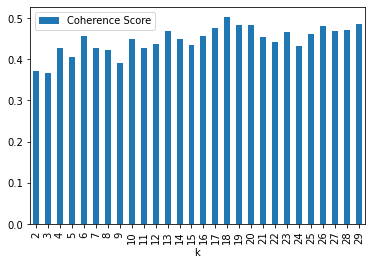

In [64]:
df.plot(x='k',y='Coherence Score', kind='bar')

По графику видим. что максимальное значение Coherence достигается при 18 темах. Проверяем этот результат нахаждением максимума в полученом датафрейме:

In [65]:
df = df.sort_values(by = 'Coherence Score', ascending = False)
print('max coherence:',df[:1])

max coherence:     Coherence Score   k
16         0.502311  18


In [66]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=18) #рприменяем LDA модель для 18 тем
lda_model.print_topics()

[(0,
  '0.006*"семья" + 0.006*"коронавирус" + 0.005*"королевский" + 0.004*"принц" + 0.004*"российский" + 0.004*"учёный" + 0.004*"компания" + 0.004*"вакцина" + 0.003*"россия" + 0.003*"власть"'),
 (1,
  '0.017*"новый" + 0.015*"коронавирус" + 0.015*"россия" + 0.008*"санкт-петербург" + 0.008*"москва" + 0.007*"полиция" + 0.007*"зафиксировать" + 0.007*"московский" + 0.007*"исход" + 0.007*"летальный"'),
 (2,
  '0.014*"ребёнок" + 0.008*"россия" + 0.008*"новый" + 0.006*"коронавирус" + 0.005*"родитель" + 0.005*"санкт-петербург" + 0.005*"летальный" + 0.005*"исход" + 0.005*"московский" + 0.005*"москва"'),
 (3,
  '0.012*"россия" + 0.011*"коронавирус" + 0.007*"санкт-петербург" + 0.007*"работа" + 0.007*"сша" + 0.006*"вакцина" + 0.005*"мир" + 0.005*"новый" + 0.005*"акция" + 0.004*"данные"'),
 (4,
  '0.008*"навальный" + 0.006*"новый" + 0.006*"москва" + 0.005*"дело" + 0.005*"коронавирус" + 0.005*"россия" + 0.005*"группа" + 0.005*"традиционный" + 0.004*"концерт" + 0.004*"лентач"'),
 (5,
  '0.011*"россия"

In [67]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.116723  0.005288       1        1  11.613203
8     -0.117399 -0.058632       2        1  10.805951
11    -0.029680  0.101990       3        1   7.728507
17    -0.094891 -0.054790       4        1   7.721996
15    -0.052181 -0.005854       5        1   5.865102
7     -0.075736 -0.022831       6        1   5.491170
12     0.015474  0.051220       7        1   5.402168
1     -0.011344  0.100904       8        1   4.886252
10    -0.019154  0.050843       9        1   4.798911
5      0.053058 -0.081176      10        1   4.775275
14     0.030755 -0.025287      11        1   4.623723
0      0.055743 -0.085219      12        1   4.376692
3      0.007831  0.010469      13        1   4.240765
4      0.060529  0.044285      14        1   4.194203
16     0.085537 -0.002275      15        1   3.953151
6      0.052276 -0.012371      16        1   3.677621
9      0.077478 -0.069625      17        1   3.170993
2      0.078427  0.053062      18        1   2.674318, topic_info=               Term        Freq       Total Category  logprob  loglift
171           новый   83.000000   83.000000  Default  30.0000  30.0000
20           россия  154.000000  154.000000  Default  29.0000  29.0000
63          вакцина  140.000000  140.000000  Default  28.0000  28.0000
217         ребёнок   38.000000   38.000000  Default  27.0000  27.0000
248   зафиксировать   34.000000   34.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
31          мужчина    1.192260   28.874753  Topic18  -5.8779   0.4344
292           число    1.110708   29.039864  Topic18  -5.9488   0.3578
35      полицейский    1.074450   12.924127  Topic18  -5.9820   1.1342
223            банк    1.074450    8.618223  Topic18  -5.9820   1.5394
1272         борьба    1.074450   11.173632  Topic18  -5.9820   1.2797

[1355 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4664     16  0.735159     16-летний
3997     13  0.753845        1980-й
3234      2  0.563929     70-летний
447      11  0.713383     85-летний
1890     13  0.753845  telegram-бот
...     ...       ...           ...
1602     12  0.177902      японский
1602     15  0.177902      японский
2657      5  0.378302         яркий
2657     13  0.378302         яркий
4989      4  0.632629      ​​лентач

[3165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 9, 12, 18, 16, 8, 13, 2, 11, 6, 15, 1, 4, 5, 17, 7, 10, 3])

Вывод: даже при нахождении оптимального числа тем мы можем видеть на графике, что некоторые темы пересекаются между собой. На данном корпусе текстов LDA работает не очень хорошо, во многих темах встречаются слова, которые там по логике не должны быть. Я уверен, что данная проблема напрямую связана с размером датасета. Для датасета примерно в 2-3 раза больше этого результаты будут намного точнее.